In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import netwulf as nw
from netwulf import visualize
import pandas as pd
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split
from math import log
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from preprocess import CreateGraph, SplitGraphObj
from util import  get_network_statistics, createnxgraph


Bad key "text.kerning_factor" on line 4 in
/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Graph Properties

In [66]:
decagonG=createnxgraph('TargetDecagon_Alt.csv',',')
#visualize(G)
prop_df_decagon = get_network_statistics(decagonG)

display(prop_df_decagon)

,Value
Property,
No. of connected components,13.000000
No. of Nodes,3934.000000
No. of Edges,18691.000000
Density,0.002416
Diameter,15.000000
Avg. clustering coeff.,0.000000
Avg. Degree,9.502288
Transitivity,0.000000


# Preprocessing

In [67]:
#Node2Vec Preprocessing
Decagongraph = CreateGraph('TargetDecagon_Alt.csv',',','#Drug','Gene')

In [68]:
(test_graph, 
 train_graph,
 edgelist_test, 
 edgelist_train,
 edgelist_model_selection,
 labels_test,
 labels_train,
 labels_model_selection) = SplitGraphObj(Decagongraph)

** Sampled 1869 positive and 1869 negative edges. **
** Sampled 1682 positive and 1682 negative edges. **


# Node Embeddings

In [69]:
# List of hyperparameters
#return and in-out parameter node2vec
p = 1.0
q = 1.0

#node embedding dimension
dimensions = 128

# No.of walks per node
num_walks = 10

# Length of single walk for a node
walk_length = 60

#Neighbourhood size from paper it's 'k'
window_size = 10

# epochs over corpus
num_iter = 1

workers = os.cpu_count()

In [70]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [71]:
embedding_train = node2vec_embedding(train_graph, "Train Graph")

Number of random walks for 'Train Graph': 39320


# Link Embeddings and Training

In [72]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
from random import randrange

# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
# The pipeline can be used as any other estimator and avoids leaking the test set into the train set
# The standard score of a sample x is calculated as: z = (x - u) / s. StandardScalar is used to standardize features to 
# Zero mean and unit variance -> Gaussian Dist.

# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)
    predictedl =clf.predict(link_features)
    
    #print(link_labels)
    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    skplt.metrics.plot_roc_curve(link_labels, predicted)
    plt.show()
    return roc_auc_score(link_labels, predicted[:, positive_column]), f1_score(link_labels, predictedl), accuracy_score(link_labels, predictedl)


# Binary Operators

In [73]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        edgelist_train, labels_train, embedding_train, binary_operator
    )
    score,f1,acc = evaluate_link_prediction_model(
        clf,
        edgelist_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
        "f1": f1,
        "acc":acc
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

# Evaluation and Results

### ROC-AUC, F1-Measure, Accuracy

/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


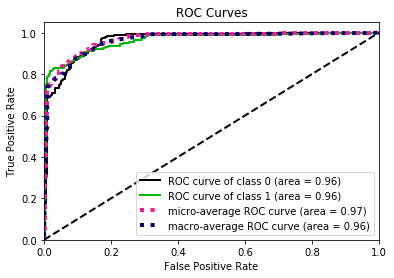

/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


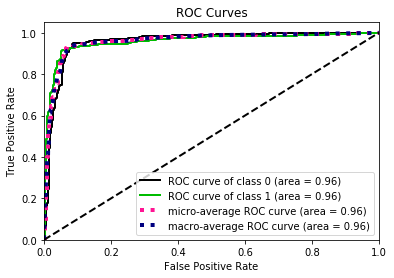

/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


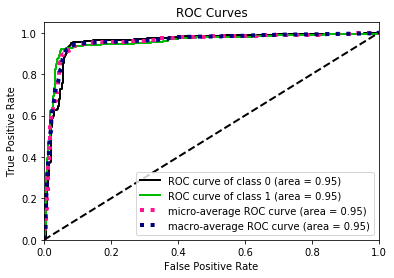

/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


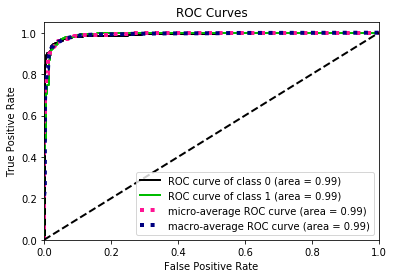

In [74]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

In [75]:
print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"],result["f1"],result["acc"]) for result in results],
    columns=("name", "ROC AUC score","F1-Score","Accuracy"),
).set_index("name")


Best result from 'operator_avg'


,ROC AUC score,F1-Score,Accuracy
name,,,
operator_hadamard,0.961785,0.892348,0.901308
operator_l1,0.958510,0.927607,0.929845
operator_l2,0.952859,0.915000,0.919144
operator_avg,0.988687,0.958482,0.958383


# Hyperparameter Tuning

### 1. Embedding Dimensions

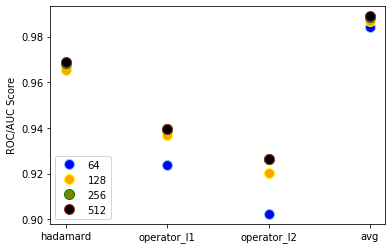

In [8]:
df1=pd.DataFrame({'x': ['hadamard','operator_l1','operator_l2','avg'], 
                 '64': [0.966239,0.923696,0.902237,0.984457],
                  '128': [0.965287,0.936814,0.920341,0.987047],
                  '256':[0.968514,0.939512,0.926153,0.988451],
                  '512':[0.969032,0.939645,0.926341,0.988944]
                  })

plt.plot( 'x', '64', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=0,label='64')
plt.plot( 'x', '128', data=df1, marker='o', markerfacecolor='orange', markersize=10, color='yellow', linewidth=0,label='128')
plt.plot( 'x', '256', data=df1, marker='o', markerfacecolor='olive', markersize=10, color='green', linewidth=0,label='256')
plt.plot( 'x', '512', data=df1, marker='o', markerfacecolor='black', markersize=10, color='brown', linewidth=0,label='512')
plt.legend()
plt.ylabel('ROC/AUC Score')
plt.savefig('Embedding_dimensions.png', bbox_inches='tight')

### 2. No. of walks

/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Second argument '8' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  # This is added back by InteractiveShellApp.init_path()


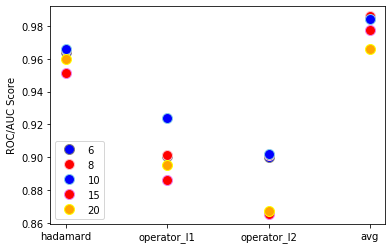

In [9]:
df1=pd.DataFrame({'x': ['hadamard','operator_l1','operator_l2','avg'], 
                 '6': [0.964217,0.900713,0.900464,0.985069],
                  '8': [0.965235,0.901240,0.901657,0.985899],
                  '10': [0.966239,0.923696,0.902237,0.984457],
                  '15': [0.951144,0.886127,0.865422,0.977606], 
                  '20': [0.959843,0.895147,0.867544,0.965958]
                  })


plt.plot( 'x', '6', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='grey', linewidth=0,label='6')
plt.plot( 'x', '8', data=df1, marker='o', markerfacecolor='red', markersize=10, color='pink', linewidth=0,label='8')
plt.plot( 'x', '10', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=0,label='10')
plt.plot( 'x', '15', data=df1, marker='o', markerfacecolor='red', markersize=10, color='violet', linewidth=0,label='15')
plt.plot( 'x', '20', data=df1, marker='o', markerfacecolor='orange', markersize=10, color='yellow', linewidth=0,label='20')
plt.ylabel('ROC/AUC Score')
plt.legend()
plt.savefig('No_of_walks.png', bbox_inches='tight')

### 3.  return and In-out Parameter (BFS:p and DFS:q)

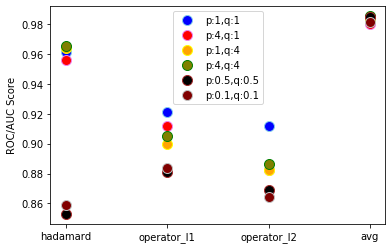

In [10]:
df1=pd.DataFrame({'x': ['hadamard','operator_l1','operator_l2','avg'], 
                 'p:1,q:1': [0.961451,0.921351,0.911551,0.984568],
                  'p:4,q:1':  [0.956040,0.911785,0.882231,0.979992],
                  'p:1,q:4': [0.964364,0.899903,0.882240,0.983120], 
                  'p:4,q:4': [0.965667,0.905280,0.886195,0.985273], 
                  'p:0.5,q:0.5':[0.852922,0.881101,0.868681,0.984525],
                  'p:0.1,q:0.1':[0.858765,0.883453,0.864132,0.981631]
                  })
plt.plot( 'x', 'p:1,q:1', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=0,label='p:1,q:1')
plt.plot( 'x', 'p:4,q:1', data=df1, marker='o', markerfacecolor='red', markersize=10, color='violet', linewidth=0,label='p:4,q:1')
plt.plot( 'x', 'p:1,q:4', data=df1, marker='o', markerfacecolor='orange', markersize=10, color='yellow', linewidth=0,label='p:1,q:4')
plt.plot( 'x', 'p:4,q:4', data=df1, marker='o', markerfacecolor='olive', markersize=10, color='green', linewidth=0,label='p:4,q:4')
plt.plot( 'x', 'p:0.5,q:0.5', data=df1, marker='o', markerfacecolor='black', markersize=10, color='brown', linewidth=0,label='p:0.5,q:0.5')
plt.plot( 'x', 'p:0.1,q:0.1', data=df1, marker='o', markerfacecolor='maroon', markersize=10, color='silver', linewidth=0,label='p:0.1,q:0.1')
plt.ylabel('ROC/AUC Score')
plt.legend()
plt.savefig('p_and_q.png', bbox_inches='tight')

### 4. Walk Length

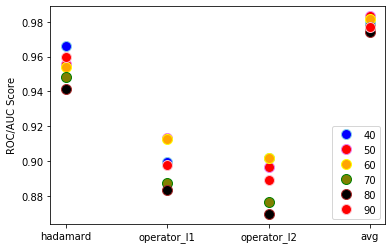

In [11]:
df1=pd.DataFrame({'x': ['hadamard','operator_l1','operator_l2','avg'], 
                 '40': [0.965973,0.899313,0.901976,0.979459],
                  '50': [0.955978,0.913032,0.896327,0.983142],
                  '60': [0.954156,0.912415,0.901452,0.981619],
                  '70':[0.948549,0.887125,0.876415,0.976841],
                  '80':[0.941431,0.883516,0.869541,0.974157],
                  '90':[0.959581,0.897608,0.888955,0.976739]
                  
                  })

plt.plot( 'x', '40', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=0,label='40')
plt.plot( 'x', '50', data=df1, marker='o', markerfacecolor='red', markersize=10, color='violet', linewidth=0,label='50')
plt.plot( 'x', '60', data=df1, marker='o', markerfacecolor='orange', markersize=10, color='yellow', linewidth=0,label='60')
plt.plot( 'x', '70', data=df1, marker='o', markerfacecolor='olive', markersize=10, color='green', linewidth=0,label='70')
plt.plot( 'x', '80', data=df1, marker='o', markerfacecolor='black', markersize=10, color='brown', linewidth=0,label='80')
plt.plot( 'x', '90', data=df1, marker='o', markerfacecolor='red', markersize=10, color='pink', linewidth=0,label='90')
plt.ylabel('ROC/AUC Score')
plt.legend()
plt.savefig('Walk_length.png', bbox_inches='tight')

### 5. Final analysis for Average Operator 

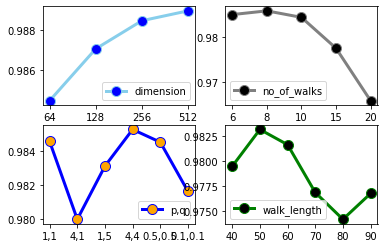

In [12]:
fig, axs = plt.subplots(2, 2)

x1= ['64','128','256','512']
x2= ['6','8','10','15','20']
x3= ['1,1','4,1','1,5','4,4','0.5,0.5','0.1,0.1']
x4= ['40','50','60','70','80','90']
                  
dimension= [0.984457,0.987047,0.988451,0.988944]
no_of_walks= [0.985069,0.985899,0.984457,0.977606,0.965958]
pq= [0.984568,0.979992,0.983120,0.985273,0.984525,0.981631]
walk_length=[0.979459,0.983142,0.981619,0.976841,0.974157,0.976739]
                  
                  

axs[0, 0].plot( x1, dimension, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=3,label='dimension')
axs[0, 0].legend()
axs[0, 1].plot( x2, no_of_walks, marker='o', markerfacecolor='black', markersize=10, color='grey', linewidth=3,label='no_of_walks')
axs[0, 1].legend()
axs[1, 0].plot( x3, pq,  marker='o', markerfacecolor='orange', markersize=10, color='blue', linewidth=3,label='p,q')
axs[1, 0].legend()
axs[1, 1].plot( x4, walk_length, marker='o', markerfacecolor='black', markersize=10, color='green', linewidth=3,label='walk_length')
axs[1, 1].legend()
plt.savefig('Decagon_Collated.png', bbox_inches='tight')
#plot.show()

# Model Test

In [76]:
embedding_test = node2vec_embedding(test_graph, "Test Graph")

Number of random walks for 'Test Graph': 39320


/home/apurv/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


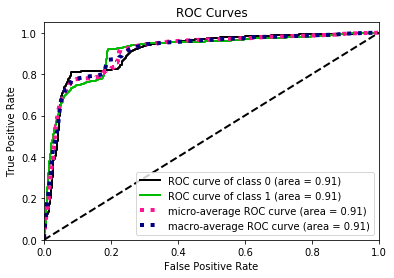

ROC AUC score on test set using 'operator_avg': 0.9099214150163706
F1 score on test set 0.805202148713599
Accuracy score on test set 0.8156768325307651


In [77]:
test_score,f1,acc = evaluate_link_prediction_model(
    best_result["classifier"],
    edgelist_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
    
)
#best_result["binary_operator"],
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)
print(
    "F1 score on test set {}".format(f1)
)
print(
    "Accuracy score on test set {}".format(acc)
)